# Test Case 8 - Two Inductances

In [116]:
from CircuitCalculator.Circuit.state_space_model import state_space_model
from CircuitCalculator.Circuit.circuit import Circuit, transform_circuit
from CircuitCalculator.Circuit import components as cmp
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt

## Setup Circuit

In [117]:
R1, R2 = 10, 20
L1, L2 = 0.1, 0.2
V0 = 5
circuit = Circuit([
    cmp.dc_voltage_source(id='Uq', V=V0, nodes=('1', '0')),
    cmp.resistor(id='R1', R=R1, nodes=('1', '2')),
    cmp.inductance(id='L1', L=L1, nodes=('2', '3')),
    cmp.resistor(id='R2', R=R2, nodes=('3', '0')),
    cmp.inductance(id='L2', L=L2, nodes=('3', '0')),
    cmp.ground(nodes=('0',))
])

In [118]:
network=transform_circuit(circuit, w=0)

### Setup Solution

In [119]:
def step(t: np.ndarray) -> np.ndarray:
    return np.heaviside(t, 1)

In [120]:
t_max = 0.02
t0 = 0.001
Ts = t_max/1000
t = np.arange(0, t_max, Ts)
V = V0*step(t-t0)

### Calculate Solution

In [121]:
from numpy.linalg import inv
from CircuitCalculator.Network.NodalAnalysis.node_analysis import *
import CircuitCalculator.Network.NodalAnalysis.label_mapping as map
node_mapping = map.default_node_mapper(network)
voltage_source_mapper = map.alphabetic_voltage_source_mapper

l_labels = {'L1': L1, 'L2': L2}

A_tilde = nodal_analysis_coefficient_matrix(network).real

source_mapping = map.filter(map.default_source_mapper(network), lambda x: x not in l_labels)
Qi = source_incidence_matrix(
        network=network)

source_mapping_all = map.default_source_mapper(network)
voltage_source_mapping = map.filter(voltage_source_mapper(network), lambda x: x not in l_labels)
inductance_mapping = map.filter(voltage_source_mapper(network), lambda x: x in l_labels)
voltage_source_mapping_all = voltage_source_mapper(network)

Q = np.zeros((voltage_source_mapping_all.N, voltage_source_mapping_all.N), dtype=int)
for i in voltage_source_mapping_all.values:
    Q[i][i] = 1
Q = np.vstack((np.hstack( (Qi, np.zeros((Qi.shape[0], Q.shape[1]) ))),
               np.hstack( (np.zeros((Q.shape[0], Qi.shape[1])), Q) )))

QS = Q[:,source_mapping.values]
QL = Q[:,inductance_mapping.values]

L_inv = np.diag([1/L for L in l_labels.values()])

A = L_inv@inv(QL.T@inv(A_tilde)@QL)
B = -A @ QL.T@inv(A_tilde)@QS

C = inv(A_tilde)@QL@inv(L_inv)@A
D = inv(A_tilde)@(QS+QL@inv(L_inv)@B)

In [122]:
sys = signal.StateSpace(A, B, C, D)
tout, yout, out = signal.lsim(sys, V, t)

### Calculate Reference Solution

In [123]:
def quad_equation(b, c):
    return (-b+np.sqrt(b**2-4*c))/2, (-b-np.sqrt(b**2-4*c))/2

x1, x2 = quad_equation(R2/L1+R1/L1+R2/L2, R1*R2/L1/L2)

t_ref = tout[tout>t0]-t0

phi3_ref = np.zeros(tout.size)
phi3_ref[tout>t0] = V0*R2/L1 * (np.exp(x1*t_ref)-np.exp(x2*t_ref))/(x1-x2)

iL1_ref = np.zeros(tout.size)
iL1_ref[tout>t0] = V0*R2/L1/L2*(x2*np.exp(x1*t_ref)-x1*np.exp(x2*t_ref)-x2+x1)/(x1*x2*(x1-x2)) + V0/L1*(np.exp(x2*t_ref)-np.exp(x1*t_ref))/(x2-x1)

iL2_ref = iL1_ref - phi3_ref/R2

phi2_ref = V-iL1_ref*R1
phi1_ref = V

iS_ref = -iL1_ref

In [124]:
V0*R2/L1/L2*(x2*np.exp(x1*0)-x1*np.exp(x2*0)-x2)/(x1*x2*(x1-x2))

0.03867513459481294

### Plot Solution

(0.0, 0.02)

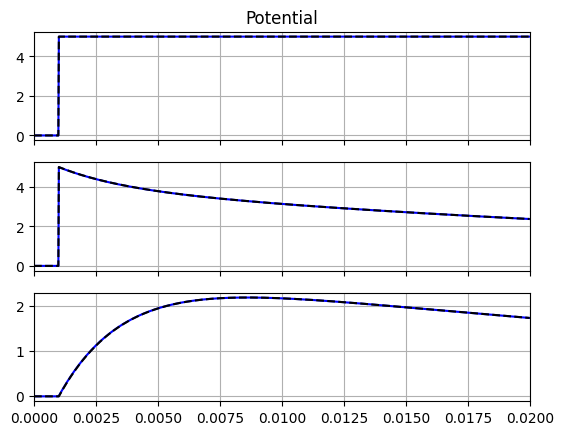

In [125]:
_, ax = plt.subplots(nrows=3, sharex=True)
ax[0].plot(tout, yout[:,0], 'b-')
ax[0].plot(t, phi1_ref, 'k--')
ax[0].grid(True)
ax[0].set_title('Potential')

ax[1].plot(tout, yout[:,1], 'b-')
ax[1].plot(tout, phi2_ref, 'k--')
ax[1].grid(True)

ax[2].plot(tout, yout[:,2], 'b-')
ax[2].plot(tout, phi3_ref, 'k--')
ax[2].grid(True)
ax[2].set_xlim((0, t_max))

(0.0, 0.02)

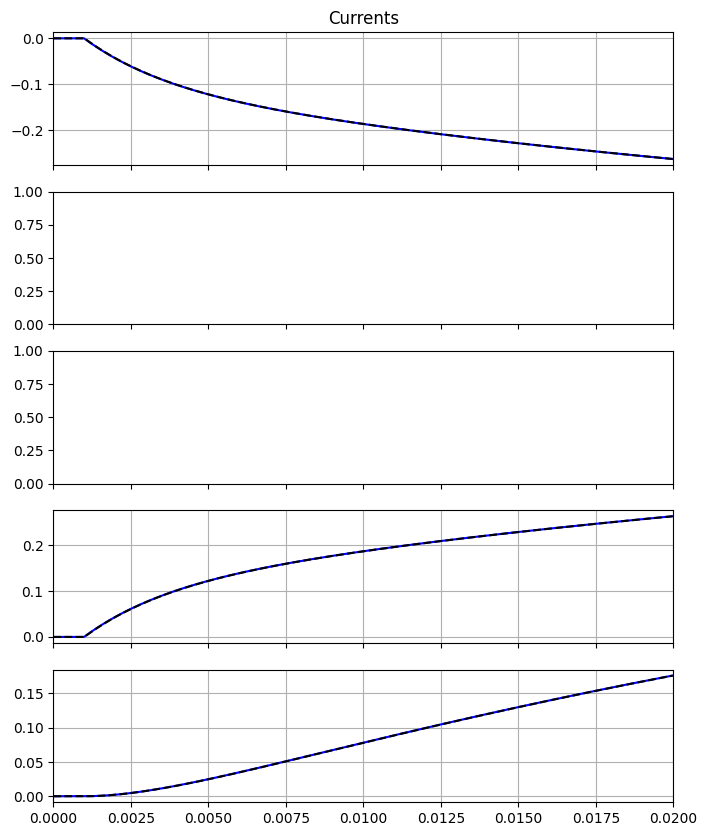

In [126]:
_, ax = plt.subplots(nrows=5, sharex=True, figsize=(8, 10))
ax[0].plot(tout, yout[:,5], 'b-')
ax[0].plot(t, iS_ref, 'k--')
ax[0].grid(True)
ax[0].set_title('Currents')

# ax[1].plot(tout, yout[:,9], 'b-')
# ax[1].plot(tout, i1_ref, 'k--')
# ax[1].grid(True)

# ax[2].plot(tout, yout[:,10], 'b-')
# ax[2].plot(tout, i2_ref, 'k--')
# ax[2].grid(True)


ax[3].plot(tout, yout[:,3], 'b-')
ax[3].plot(tout, iL1_ref, 'k--')
ax[3].grid(True)

ax[4].plot(tout, yout[:,4], 'b-')
ax[4].plot(tout, iL2_ref, 'k--')
ax[4].grid(True)
ax[4].set_xlim((0, t_max))